In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
import torch.nn as nn
from torchvision import models, transforms, utils
from torchvision.transforms.functional import normalize, resize, to_pil_image
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

In [3]:
df = pd.read_csv('train.csv')
df['path'] = df['id_code'].map(lambda x: os.path.join(os.getcwd(), 'train_images', f'{x}.png'))
df = df.drop(columns=['id_code'])
df.head(5)

,diagnosis,path
0,2,/Users/aarshpatel/Downloads/Blindness Detectio...
1,4,/Users/aarshpatel/Downloads/Blindness Detectio...
2,1,/Users/aarshpatel/Downloads/Blindness Detectio...
3,0,/Users/aarshpatel/Downloads/Blindness Detectio...
4,0,/Users/aarshpatel/Downloads/Blindness Detectio...


In [4]:
x_train = df['path']

y_train = pd.get_dummies(df['diagnosis']).values

y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


In [5]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train_multi, test_size=0.2, random_state=21)

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, paths, label, transform=None):
        self.paths = paths
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths.iloc[idx]
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(self.label[idx], dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)

        return image, label

# Define data augmentation transformations
aug_transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(degrees=360),
    v2.RandomPerspective(distortion_scale=0, p=1, interpolation=3),
    v2.RandomAffine(degrees=0, translate=(0, 0), scale=(1, 1), shear=0),
    v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0, hue=0),
])

# Define the main transformation pipeline
transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomApply([aug_transforms], p=0.5),  # Apply augmentations with 50% probability
    # v2.ToTensor(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create custom datasets and dataloaders for training and validation
train_dataset = CustomImageDataset(x_train,y_train, transform=transform)
val_dataset = CustomImageDataset(x_val,y_val, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


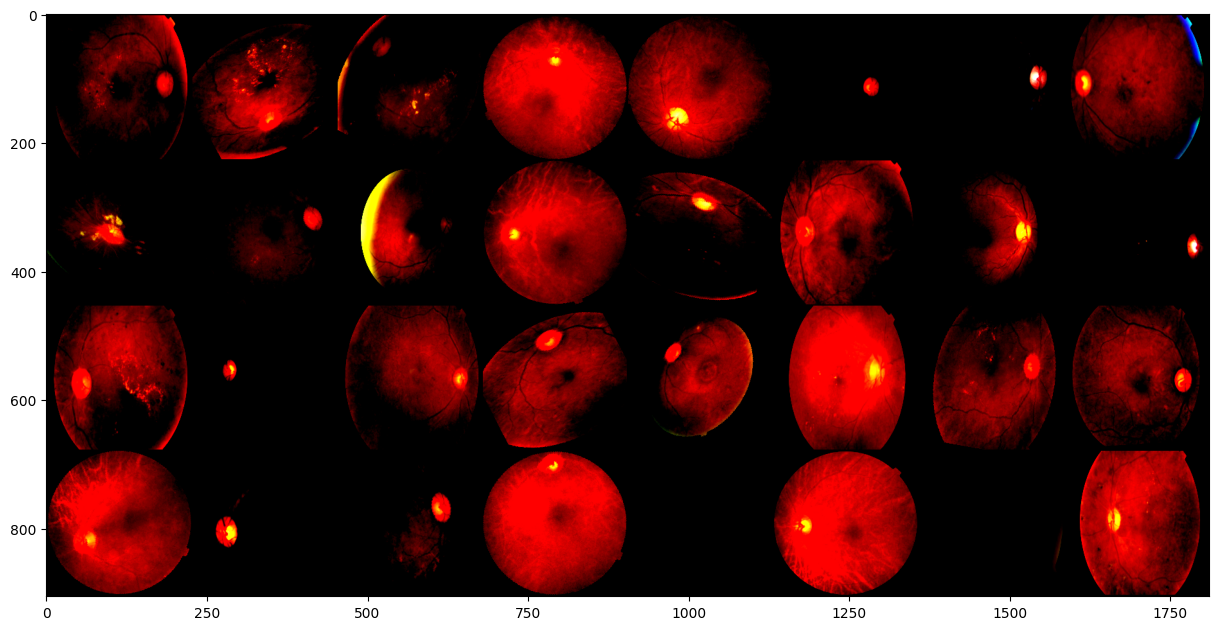

In [7]:

def show_batch(batch):
    images, labels = batch
    grid_img = utils.make_grid(images, nrow=8)
    grid_img = np.transpose(grid_img, (1, 2, 0))
    # print(images.size())
    plt.figure(figsize=(15, 15))
    plt.imshow(grid_img)
    plt.show()

# Iterate over the train_dataloader and visualize a batch
for batch in train_dataloader:
    show_batch(batch)
    break  # Stop after visualizing the first batch

In [ ]:
# Load pre-trained ResNet-50
resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')

# Modify the final fully connected layer for your specific classification task
num_classes = y_train_multi.shape[1]  # Assuming you have 5 classes
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, num_classes),
    nn.Sigmoid()  # Assuming you want sigmoid activation for multilabel classification
)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
resnet.to(device)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    resnet.train()

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation
    resnet.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            val_loss += criterion(outputs, labels).item()

            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    val_loss /= len(val_dataloader)

    # Flatten predictions and labels for Quadratic Weighted Kappa calculation
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Convert predictions to class labels
    pred_labels = np.round(all_preds).astype(int)
    true_labels = all_labels.astype(int)

    # Calculate Quadratic Weighted Kappa
    qwk = cohen_kappa_score(true_labels.sum(axis=1)-1, pred_labels.sum(axis=1)-1, weights='quadratic')

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, QWK: {qwk:.4f}')

# Save the trained model
torch.save(resnet.state_dict(), 'resnet50.pth')


In [8]:
# Load the test image
test_image_path = 'train_images/0024cdab0c1e.png'
test_image = Image.open(test_image_path).convert("RGB")

# Define the transformation pipeline for test images
test_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply transformations to the test image
test_image = test_transform(test_image)

# If you're using GPU, move the image to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
test_image = test_image.to(device)

# Load the trained model
resnet = models.resnet50(pretrained=True)
num_classes = 5  # Assuming you have 5 classes
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, num_classes),
    nn.Sigmoid()
)
resnet.load_state_dict(torch.load('ResNet50.pth', map_location=device))
resnet.to(device)
resnet.eval()

# Perform inference
with torch.no_grad():
    outputs = resnet(test_image.unsqueeze(0))  # Add a batch dimension

# Convert the output probabilities to predicted labels
predicted_labels = np.round(outputs.cpu().numpy()).astype(int)

print("Predicted labels:", predicted_labels)


/Users/aarshpatel/Downloads/Blindness Detection/.venv/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/Users/aarshpatel/Downloads/Blindness Detection/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/aarshpatel/Downloads/Blindness Detection/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-

Predicted labels: [[1 1 0 0 0]]


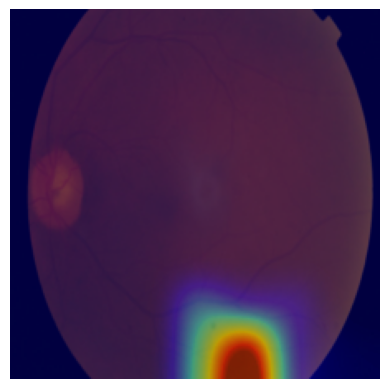

In [10]:
test_image_path = 'train_images/0024cdab0c1e.png'
test_image = Image.open(test_image_path).convert("RGB")

preprocess = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
original_image_preprocess = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
])
test_image_tensor = preprocess(test_image)
original_image_tensor = original_image_preprocess(test_image)

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
test_image_tensor = test_image_tensor.to(device)
original_image_tensor = original_image_tensor.to(device)

model = models.resnet50(pretrained=True)
num_classes = 5 # Number of predicted classes
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, num_classes),
    nn.Sigmoid()
)
model.load_state_dict(torch.load('ResNet50.pth', map_location=device))
model.to(device)
model.eval()

last_conv_layer = 'layer4'
cam_extractor = GradCAM(model, last_conv_layer)
out = model(test_image_tensor.unsqueeze(0)) 
predicted_class = int(np.round(out.cpu().detach().numpy()).astype(int).sum() - 1)
cams = cam_extractor(predicted_class, out)


result = overlay_mask(to_pil_image(original_image_tensor), to_pil_image(cams[0].squeeze(0), mode='F'), alpha=0.5) 
plt.imshow(result)
plt.axis('off')
plt.show()

In [11]:
def get_predicted_label_and_gradcam(image, model, last_conv_layer):
    preprocess = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    original_image_preprocess = v2.Compose([
        v2.Resize((224, 224)),
        v2.ToTensor(),
    ])

    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

    image = image.convert("RGB")
    test_image_tensor = preprocess(image)
    original_image_tensor = original_image_preprocess(image)

    test_image_tensor = test_image_tensor.to(device)
    original_image_tensor = original_image_tensor.to(device)

    model.to(device)
    model.eval()

    cam_extractor = GradCAM(model, last_conv_layer)
    out = model(test_image_tensor.unsqueeze(0)) 
    predicted_class = int(np.round(out.cpu().detach().numpy()).astype(int).sum() - 1)
    cams = cam_extractor(predicted_class, out)

    # resized_gradcam = torch.nn.functional.interpolate(cams[0].unsqueeze(0), size=original_image_tensor.shape[-2:], mode='bilinear', align_corners=False)
    # gradcam_image = overlay_mask(to_pil_image(original_image_tensor), to_pil_image(resized_gradcam.squeeze(0), mode='F'), alpha=0.5)
    gradcam_image = overlay_mask(to_pil_image(original_image_tensor), to_pil_image(cams[0].squeeze(0), mode='F'), alpha=0.5)

    return predicted_class, gradcam_image

In [20]:
# Example usage:
test_image_path = 'train_images/f68690db78d3.png'
image = Image.open(test_image_path)

model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
num_classes = 5 # Number of predicted classes
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, num_classes),
    nn.Sigmoid()
)
model.load_state_dict(torch.load('ResNet50.pth', map_location=torch.device("mps")))

last_conv_layer = 'layer4'

predicted_label, gradcam_images = get_predicted_label_and_gradcam(image, model, last_conv_layer)

print("Predicted Label:", predicted_label)
plt.imshow(gradcam_images)
plt.axis('off')
plt.show()
